In [51]:
%matplotlib inline
import copy
import qutip
from qutip import Qobj
import numpy as np
import math, cmath
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## 1) Create a thermal state

In [52]:
def thermal_state(ndims, omega, T, plotdiag=False):
    diagonal = np.arange(ndims)
    exponents = np.exp(- omega * diagonal / T)
    return np.diag(exponents) / np.sum(exponents)

In [67]:
# Define the dimensions of the system's Hilbert space
ndims = 25

# Define the energy of the system and its temperature
omega = 1.
T = 1.

rho1 = thermal_state(ndims, omega, T);
rho2 = thermal_state(ndims, omega, T);

rho = Qobj(np.kron(rho1, rho2), dims=[[ndims, ndims], [ndims, ndims]])

Quantum object: dims = [[25, 25], [25, 25]], shape = (625, 625), type = oper, isherm = True
Qobj data =
[[3.99576401e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.46995943e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.40767854e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.20778618e-21
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.54795803e-21 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.69461935e-22]]

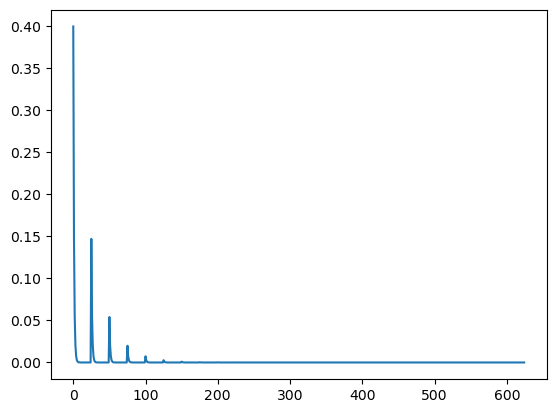

In [68]:
display(rho)
plt.plot(rho.diag())

## 2) Create Phaseonium Ancillas

In [55]:
def phaseonium(alpha, phi):
    return np.array([[alpha**2, 0, 0],
                     [0, (1 - alpha**2)/2, (1 - alpha**2)/2 * np.exp(phi*1j)],
                     [0, (1 - alpha**2)/2 * np.exp(-phi*1j), (1 - alpha**2)/2]])

def dissipation_rates(alpha, phi):
    ga = 2*alpha**2
    gb = (1 + np.cos(phi))*(1 - alpha**2)
    return np.real(ga), np.real(gb)

def final_temperature(ga, gb):
    return - 1 / np.log(ga/gb)

In [56]:
# Define excited-state population of phaseonium atoms
alpha = 1 / 4
phi = 1.585589386

# Define the interaction strength
strength = 1

# Create phaseonium density matrices
eta = Qobj(phaseonium(alpha, phi))

# And get dissipation rates
ga, gb = dissipation_rates(alpha, phi)

Tf = final_temperature(ga, gb)

print(f"Prepared Phaseonium has:\nγα = {ga},\nγβ = {gb}.\n\nIt will thermalize at temperature T = {Tf}")

Prepared Phaseonium has:
γα = 0.125,
γβ = 0.9236320128073691.

It will thermalize at temperature T = 0.49999999988062405


## 3) Create Bosonic Operators

Creation and Annihilation operators are already defined in qutip, **but** the aad must be corrected (or written as ada + 1), else it results singular and not-invertible

In [57]:
def create(ndims):
    """Bosonic Creation Operator"""
    elements = np.sqrt(np.arange(1, ndims))
    return np.diag(elements, -1)

def destroy(ndims):
    """Bosonic Annihilation Operator"""
    elements = np.sqrt(np.arange(1, ndims))
    return np.diag(elements, 1)

def dag(matrix):
    """Conjugate Adjoint of a matrix"""
    return np.conj(matrix.T)
    
np.all(create(ndims) == dag(destroy(ndims)))

True

In [58]:
def C(theta, ndims):
    a = qutip.destroy(ndims)
    argument = 2 * (a.dag() * a + 1)
    return (theta * (argument).sqrtm()).cosm()

def Cp(theta, ndims):
    a = qutip.destroy(ndims)
    argument = 2 * a.dag() * a
    return (theta * (argument).sqrtm()).cosm()

def S(theta, ndims):
    a = qutip.destroy(ndims)
    argument = 2 * (a.dag() * a + 1)
    sineop = (theta * (argument).sqrtm()).sinm()
    dividend = (argument.sqrtm()).inv()  # pseudoinverse
    return a.dag() * sineop * dividend

def Sd(theta, ndims):
    return S(theta, ndims).dag()

## 4) System Evolution

### 4.1) Define Evolution Parameters

In [59]:
dt = 1.0  # Interaction time
theta = strength * dt  # Rabi phase

timesteps = 100;

### 4.2) Define Kraus Operators

In [60]:
E0 = np.sqrt(1 - ga/2 - gb/2) * qutip.tensor(qutip.qeye(ndims), qutip.qeye(ndims))
E1 = np.sqrt(ga/2) * ( qutip.tensor(C(theta, ndims), C(theta, ndims)) -2 * qutip.tensor(S(theta, ndims), Sd(theta, ndims)) )
E2 = np.sqrt(ga) * ( qutip.tensor(S(theta, ndims), Cp(theta, ndims)) + qutip.tensor(C(theta, ndims), S(theta, ndims)) )
E3 = np.sqrt(gb) * ( qutip.tensor(Sd(theta, ndims), C(theta, ndims)) + qutip.tensor(Cp(theta, ndims), Sd(theta, ndims)) )
E4 = np.sqrt(gb/2) * ( qutip.tensor(Cp(theta, ndims), Cp(theta, ndims)) -2 * qutip.tensor(Sd(theta, ndims), S(theta, ndims)) )
kraus = (E0, E1, E2, E3, E4);

### 4.3) Write Equations of Motion

In [61]:
def D(M, rho):
    """Dissipator Operator appearing in the Master Equation"""
    sandwich = M * rho * M.dag()
    return sandwich - 1/2 * qutip.commutator(M, rho)

def meq_evolve(rho, timesteps):
    drho = Qobj(np.zeros(rho.shape), dims=rho.dims)
    for t in range(1, timesteps):
        for Ek in kraus[1:-1]:
            drho = drho + D(Ek, rho)
        rho += drho
    return rho


def kraus_evolve(rho, timesteps):
    rho_old = rho
    for t in range(1, timesteps):
        rho_new = sum([Ek * rho_old * Ek.dag() for Ek in kraus])
        rho_old = rho_new
    return rho_new

In [62]:
rhot = rho
rhot = kraus_evolve(rhot, 1000)
rhot

Quantum object: dims = [[25, 25], [25, 25]], shape = (625, 625), type = oper, isherm = False
Qobj data =
[[0.7391389  0.         0.         ... 0.         0.         0.        ]
 [0.         0.10003478 0.         ... 0.         0.         0.        ]
 [0.         0.         0.01354262 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

### 4.4) Do some benchmark

In [64]:
import cProfile
import pstats

In [65]:
import timeit

rhot = rho

def time_function(num_runs, func, *args):
    num_runs = num_runs
    duration = timeit.Timer(lambda: func(*args)).timeit(number=num_runs)
    avg_duration = duration/num_runs
    print(f'On average it took {avg_duration} seconds')
    return duration

In [69]:
def profile_func():
    rho_new = kraus_evolve(rho, 10000)
    return rho_new

# Profile the code
cProfile.run('profile_func()', 'profile_stats')

# Display the profiling results
stats = pstats.Stats('profile_stats')
stats.sort_stats('cumulative')  # You can change the sorting method
stats.print_stats()

Tue Dec 19 08:20:09 2023    profile_stats

         35608005 function calls (34848081 primitive calls) in 42.865 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   42.865   42.865 {built-in method builtins.exec}
        1    0.000    0.000   42.865   42.865 <string>:1(<module>)
        1    0.000    0.000   42.865   42.865 C:\Users\fedes\AppData\Local\Temp\ipykernel_18084\2797067713.py:1(profile_func)
        1    0.092    0.092   42.865   42.865 C:\Users\fedes\AppData\Local\Temp\ipykernel_18084\3159037405.py:15(kraus_evolve)
     9999    0.225    0.000   26.160    0.003 C:\Users\fedes\AppData\Local\Temp\ipykernel_18084\3159037405.py:18(<listcomp>)
   199980    1.938    0.000   20.904    0.000 C:\Users\fedes\anaconda3\envs\julia\Lib\site-packages\qutip\qobj.py:189(__init__)
    99990    1.007    0.000   20.198    0.000 C:\Users\fedes\anaconda3\envs\julia\Lib\site-packages\qutip\qobj.py:482(__mul

In [16]:
b1 = time_function(2, meq_evolve, rhot, 1000)

On average it took 108.20184549999999 seconds


In [46]:
b2 = time_function(6, kraus_evolve, rhot, 1000)

On average it took 2.9272455833342974 seconds


In [72]:
from tqdm import trange
def kraus_evolve(rho, timesteps):
    rho_old = rho
    for t in trange(1, timesteps):
        rho_new = sum([Ek * rho_old * Ek.dag() for Ek in kraus])
        rho_old = rho_new
    return rho_new

In [73]:
rhot = rho
rhot = kraus_evolve(rhot, 5000)

100%|█████████████████████████████████████████████████████████| 4999/4999 [00:13<00:00, 375.29it/s]


0.5000020170217216


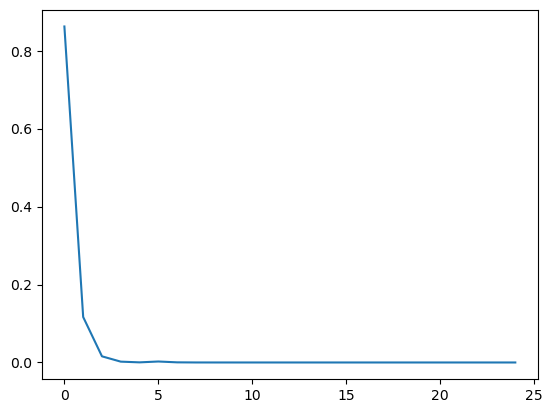

In [74]:
rho1 = rhot.ptrace(0)
rho00 = rho1.diag()[0]
rho11 = rho1.diag()[1]
Tstable = - 1 / np.log(rho11 / rho00)
print(Tstable)
plt.plot(rho1.diag())